## **Prediction of Wind Energy Generation from Wind Speed Data**

### Tyler Valentine, Theo Thormann, and Nadir Siddiqui 

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc as pm
import arviz as az
import geopandas as gpd
from shapely.geometry import Point, Polygon
import math

## **Data Source**
All data are located in the Data folder

In [2]:
# Sources of data (must be in same folder as notebook) 
shape_source = r'DEU_adm/DEU_adm0.shp'
wind_source = 'time_series_60min_singleindex.csv'
weather_source_2016 = 'weather_data_GER_2016.csv'
weather_source_2017 = 'weather_data_GER_2017.csv'

## **Data Cleaning**

## *2016*

### Hourly wind energy production data for Germany in 2016

In [3]:
# Import data and only keep 2016 measurements
wind = pd.read_csv(wind_source, 
                   usecols = ('utc_timestamp', 'DE_wind_generation_actual'),
                   parse_dates=[0], 
                   index_col=0)
wind_2016 = wind.loc[wind.index.year == 2016, :]

# Rename the columns
wind_2016 = wind_2016.rename(columns={"DE_wind_generation_actual": "wind"})
wind_2016.index.name = 'time'

# Remove timezone
wind_2016.index = pd.to_datetime(wind_2016.index)
wind_2016.index = wind_2016.index.tz_localize(None)

# Show the wind energy data 
wind_2016.head(3)

wind
time                       
2016-01-01 00:00:00  8579.0
2016-01-01 01:00:00  8542.0
2016-01-01 02:00:00  8443.0

### Hourly wind speed and measurement location data for Germany in 2016

In [4]:
# Import weather data for Germany (2016) 
weather_2016 = pd.read_csv(weather_source_2016, 
                           parse_dates=[0], 
                           index_col=0)

# Keep predictors related to wind speed and rename index 
wind_speed_2016 = weather_2016[['v1', 'v2', 'v_50m']]
wind_speed_2016.index.name = 'time'

# Remove timezone
wind_speed_2016.index = pd.to_datetime(wind_speed_2016.index)
wind_speed_2016.index = wind_speed_2016.index.tz_localize(None)

# Also keep the lat and long variables
location = weather_2016[['lat', 'lon']]
location = location.loc[location.index == '2016-01-01 00:00:00', :]
location = location.reset_index(drop=True)

In [5]:
# Show the wind speed data
wind_speed_2016.head(3)

v1    v2  v_50m
time                                  
2016-01-01 00:00:00  0.81  1.88   3.36
2016-01-01 01:00:00  0.77  1.61   2.63
2016-01-01 02:00:00  0.66  1.22   1.89

In [6]:
# Show the location data 
location.head(3)

lat    lon
0  47.5  5.625
1  47.5  6.250
2  47.5  6.875

### Wind speed data measurements include 256 locations

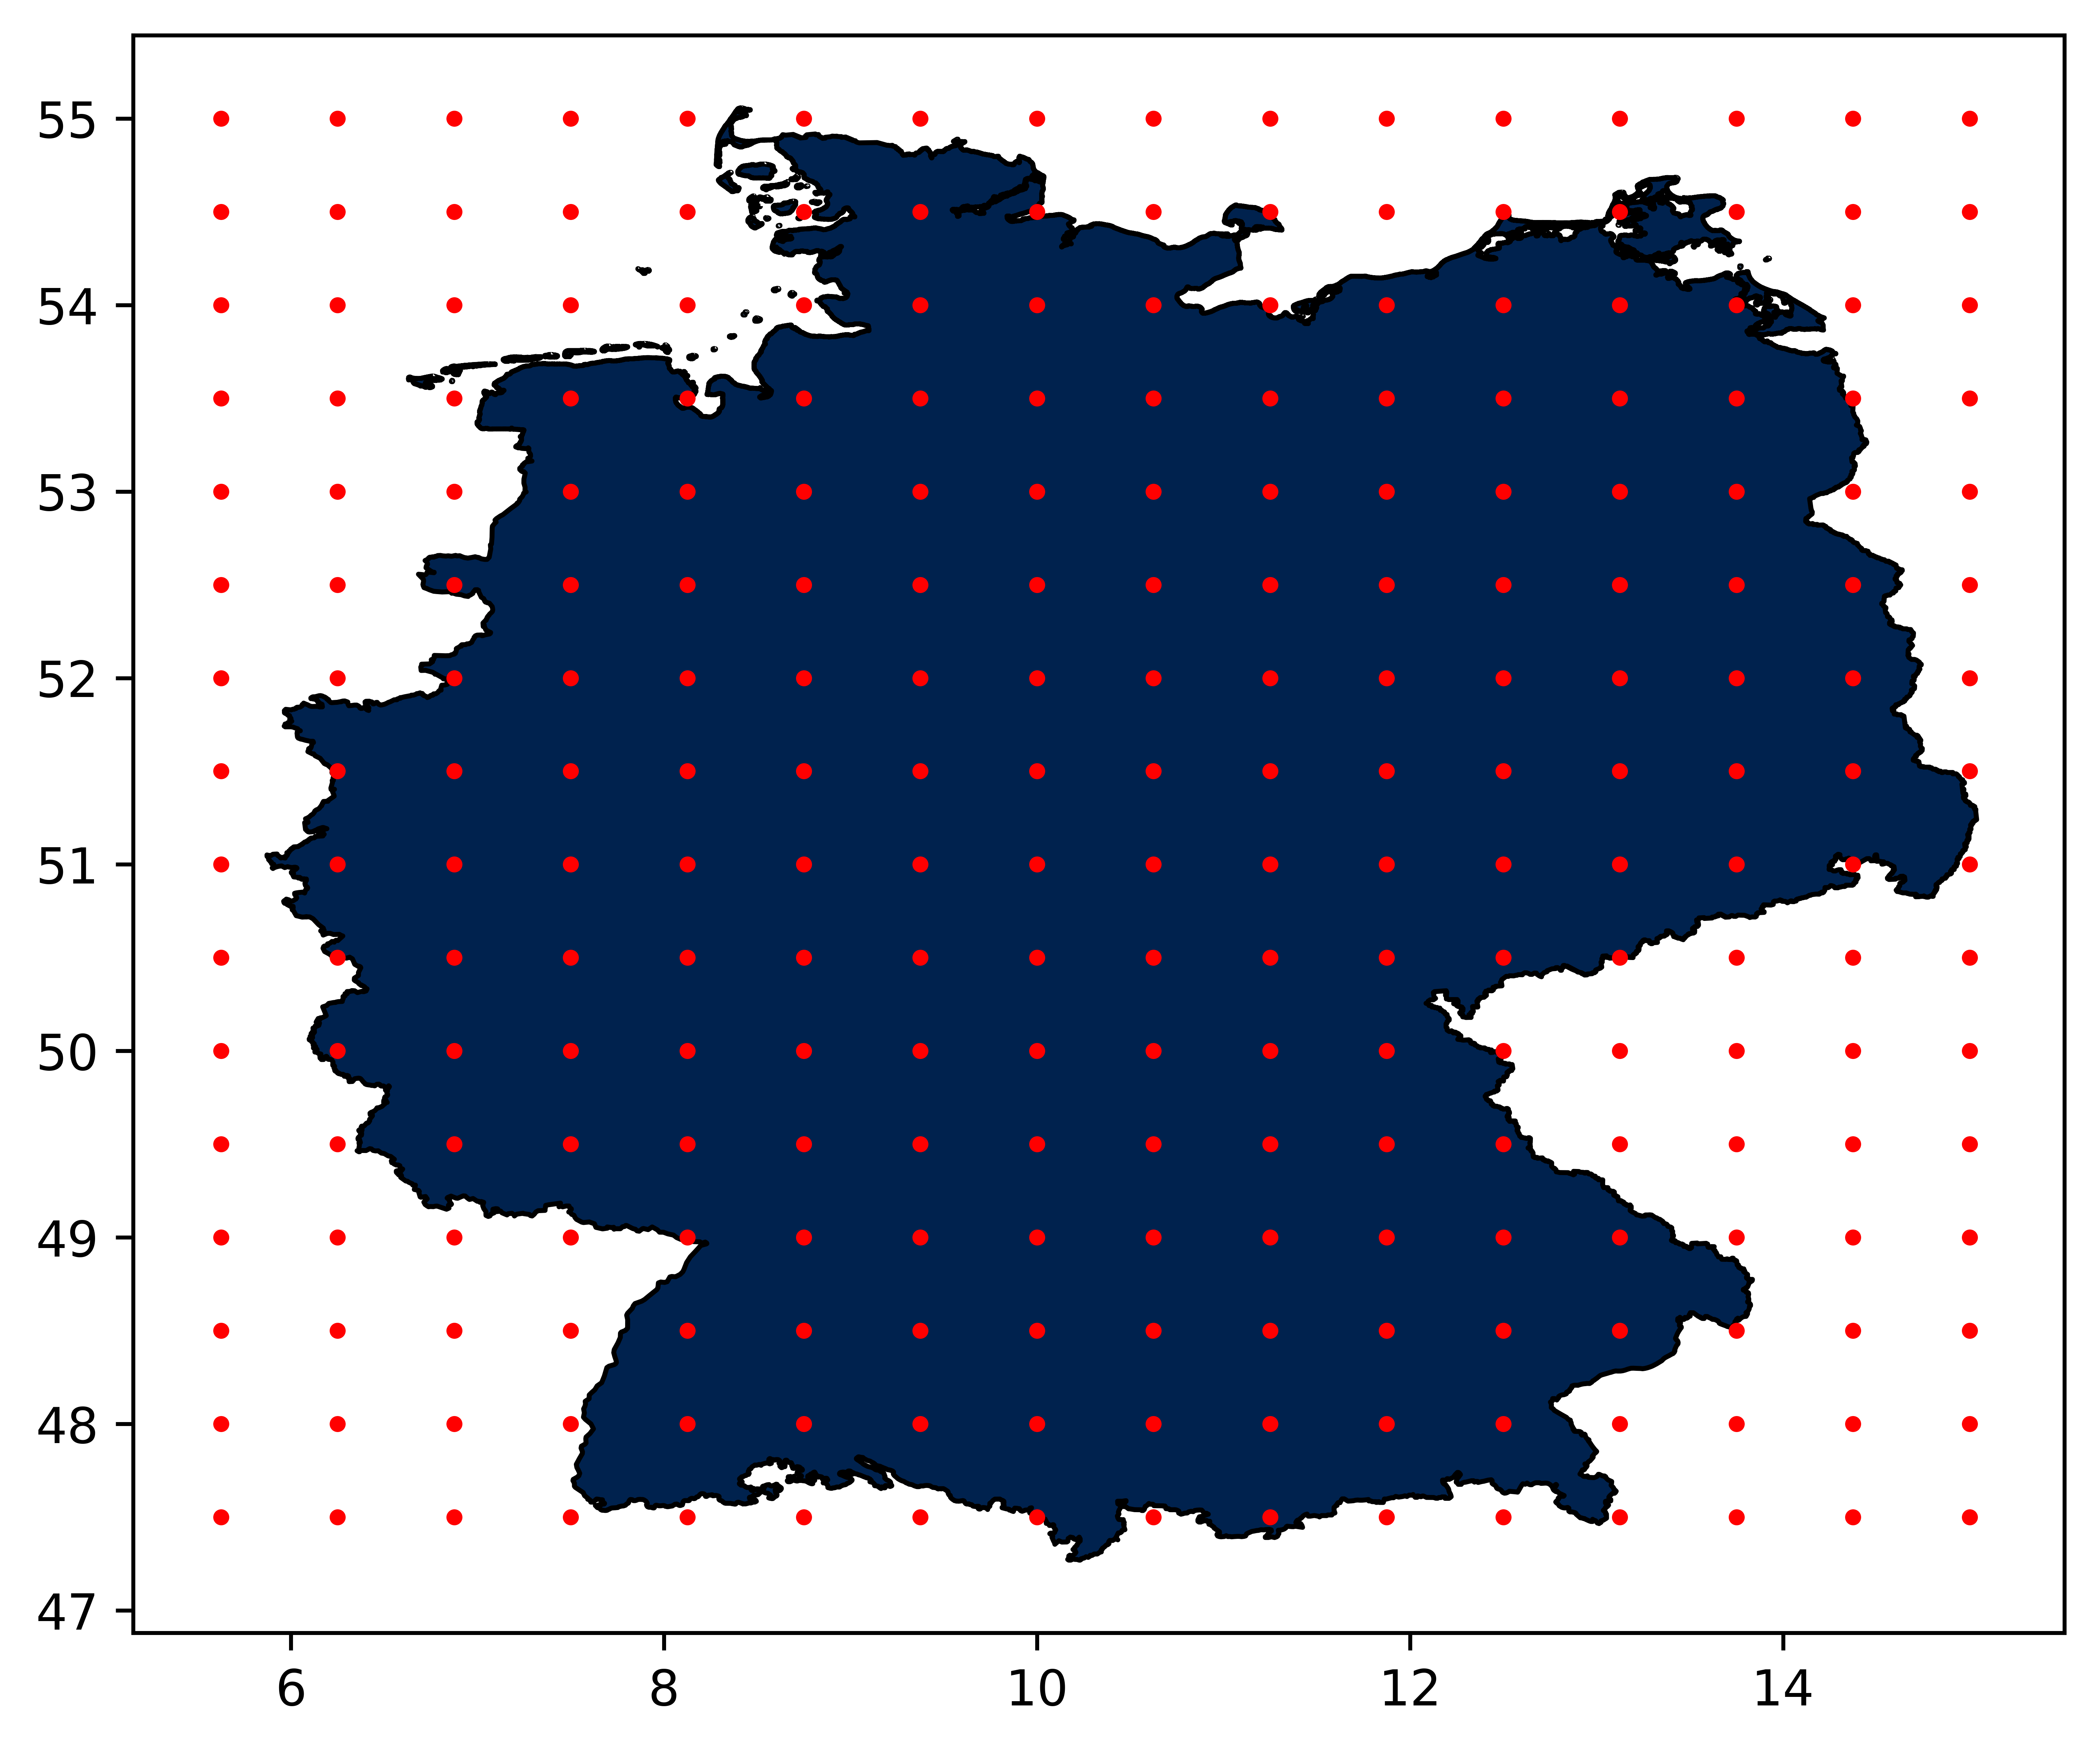

In [7]:
# Germany shapefile 
germany_shape = gpd.read_file(shape_source)

# Measurement locations
geometry = [Point(xy) for xy in zip(location.lon, location.lat)]

# Save data
geodata = gpd.GeoDataFrame(location, geometry=geometry)

# Plot data
fig, ax = plt.subplots(figsize=(7,7), dpi=1000)
germany_shape.plot(ax=ax, facecolor='Grey', edgecolor='k', alpha=1, linewidth=1, cmap='cividis')
geodata.plot(ax = ax, color = 'red', markersize=5);

### Average all 256 wind speed measurements for use in predictive model

In [8]:
wind_speed_2016 = wind_speed_2016.groupby(wind_speed_2016.index).mean()

In [9]:
# Merge production and weather data
data_2016 = pd.merge(wind_2016, wind_speed_2016, how='left', left_index=True, right_index=True)

In [10]:
# Show observations that are missing wind energy measurements 
data_2016[data_2016.isna().any(axis=1)]

# Drop 74 observations that are missing wind data 
data_2016 = data_2016.dropna()

In [11]:
# Show data
data_2016.head(3)

wind        v1        v2     v_50m
time                                                     
2016-01-01 00:00:00  8579.0  2.616758  3.714414  5.132500
2016-01-01 01:00:00  8542.0  2.564375  3.631055  4.976094
2016-01-01 02:00:00  8443.0  2.480859  3.516328  4.794688

## *2017*

### Hourly wind energy production data for Germany in 2017

In [12]:
# Import data and only keep 2017 measurements
wind_2017 = wind.loc[wind.index.year == 2017, :]

# Rename the columns
wind_2017 = wind_2017.rename(columns={"DE_wind_generation_actual": "wind"})
wind_2017.index.name = 'time'

# Remove timezone
wind_2017.index = pd.to_datetime(wind_2017.index)
wind_2017.index = wind_2017.index.tz_localize(None)

In [13]:
# Show the wind energy data 
wind_2017.head(3)

wind
time                        
2017-01-01 00:00:00  15363.0
2017-01-01 01:00:00  15080.0
2017-01-01 02:00:00  14731.0

### Hourly wind speed and measurement location data for Germany in 2017

In [14]:
# Import weather data for Germany (2017) 
weather_2017 = pd.read_csv(weather_source_2017, 
                           parse_dates=[0], 
                           index_col=11)

# Keep predictors related to wind speed and rename index 
wind_speed_2017 = weather_2017[['v_2m', 'v_10m', 'v_50m']]
wind_speed_2017.index.name = 'time'

# Remove timezone
wind_speed_2017.index = pd.to_datetime(wind_speed_2017.index)
wind_speed_2017.index = wind_speed_2017.index.tz_localize(None)

### Average all 256 wind speed measurements for use in predictive model

In [15]:
wind_speed_2017 = wind_speed_2017.groupby(wind_speed_2017.index).mean()

# Merge production and weather data
data_2017 = pd.merge(wind_2017, wind_speed_2017, how='left', left_index=True, right_index=True)

In [16]:
# Show data
data_2017.head(3)

wind      v_2m     v_10m     v_50m
time                                                      
2017-01-01 00:00:00  15363.0  3.878203  5.474687  7.332422
2017-01-01 01:00:00  15080.0  3.897109  5.507969  7.368633
2017-01-01 02:00:00  14731.0  3.906484  5.530195  7.372617

## **Exploratory Data Analysis**

In [17]:
# Show correlations between variables
import dataframe_image as dfi
df = data_2016.corr()
df.style.background_gradient(cmap ='Blues', axis=1).set_properties(**{'font-size': '20px'})

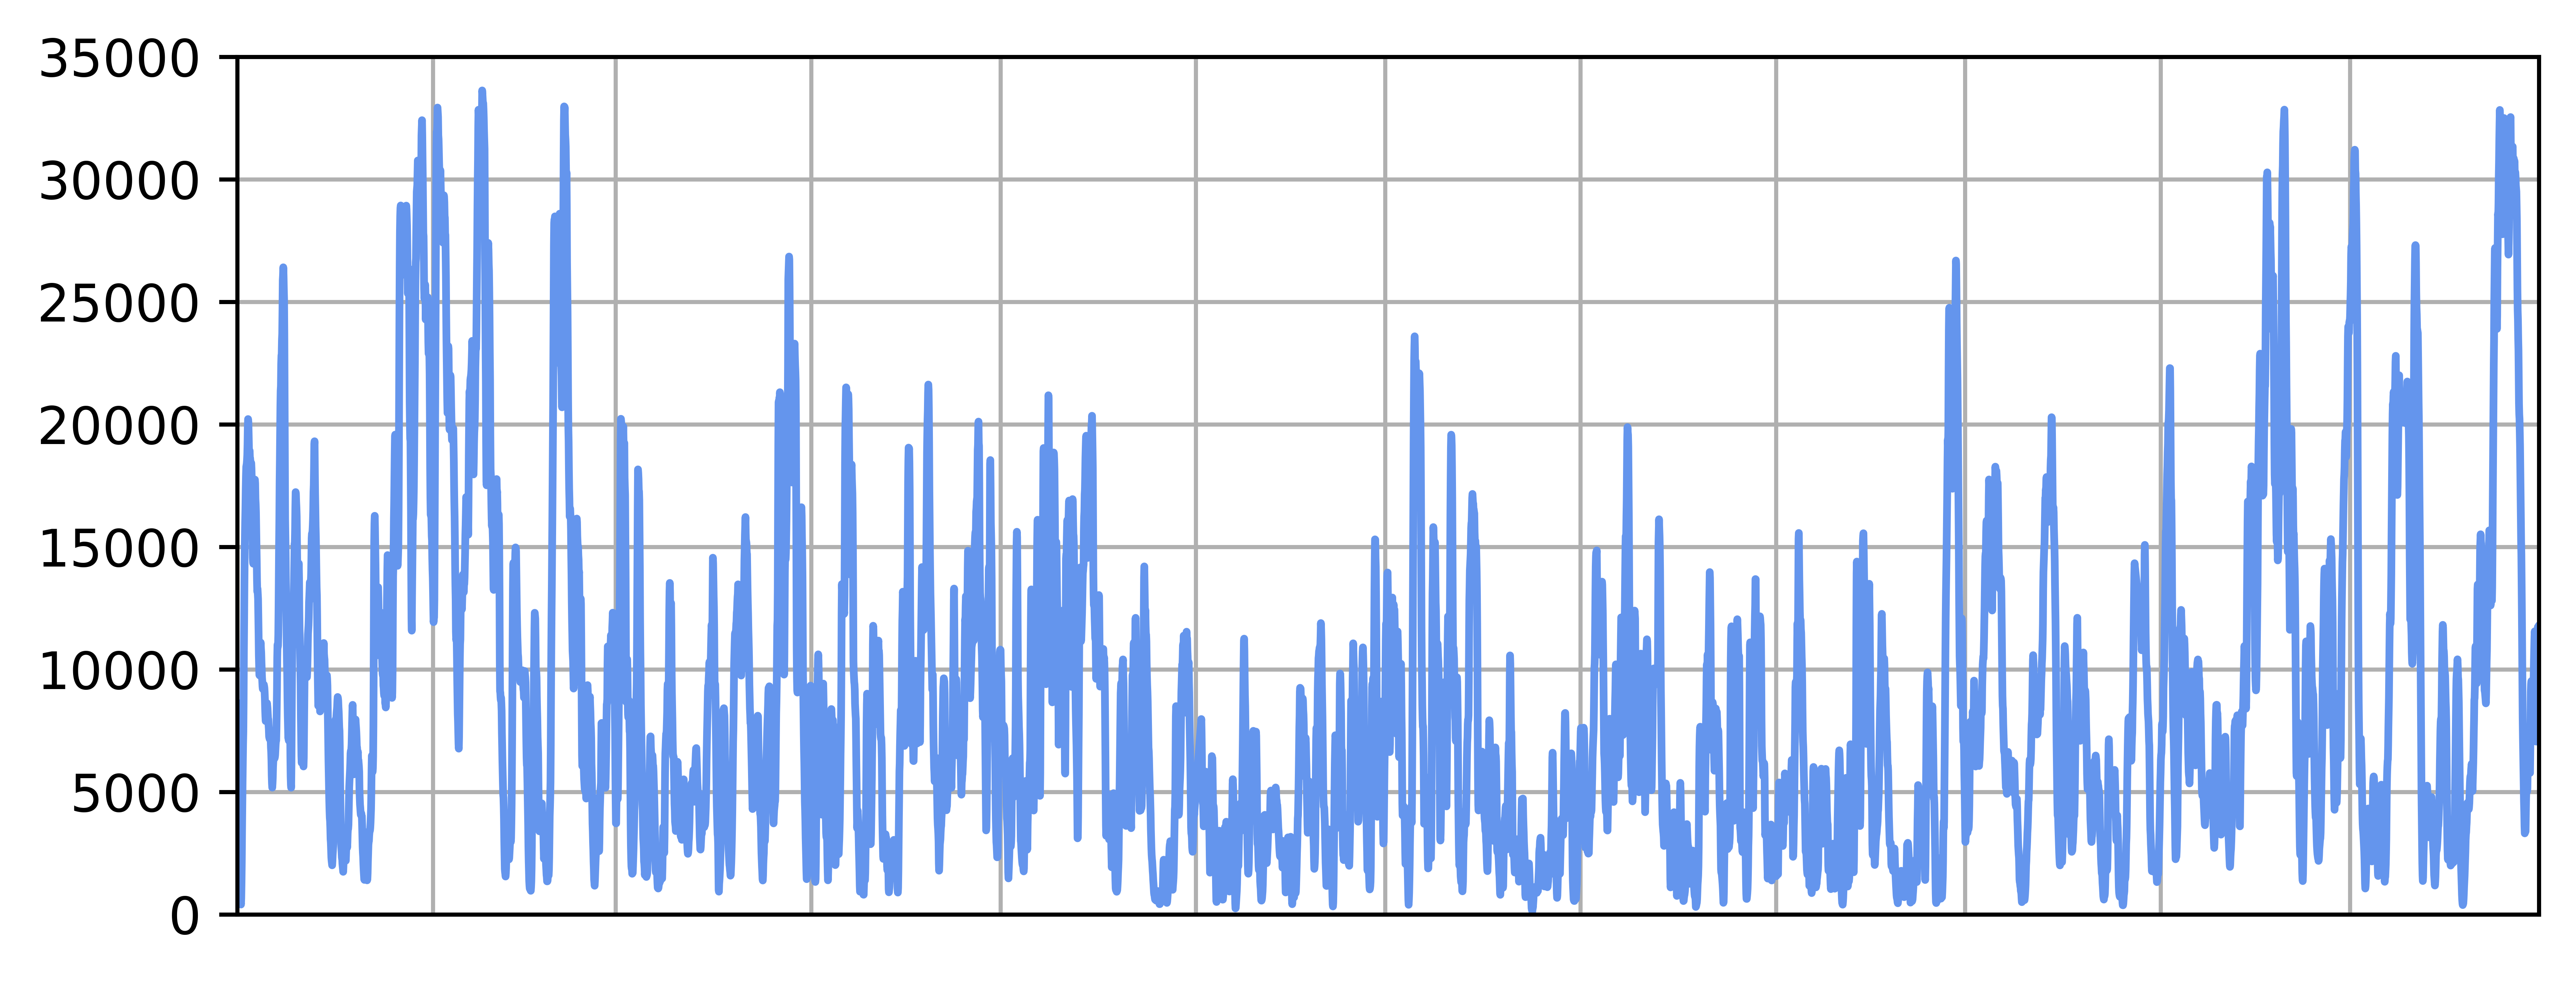

In [18]:
# Show trends in wind generation in 2016 
plt.figure(figsize=(8,3), dpi=1000)
plt.plot(data_2016.index, data_2016.wind, color='cornflowerblue')

plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-12-31'))
plt.ylim(0, 35000)

plt.tick_params(
    axis='x',        
    which='both',   
    bottom=False,    
    top=False,         
    labelbottom=False) 

plt.grid()

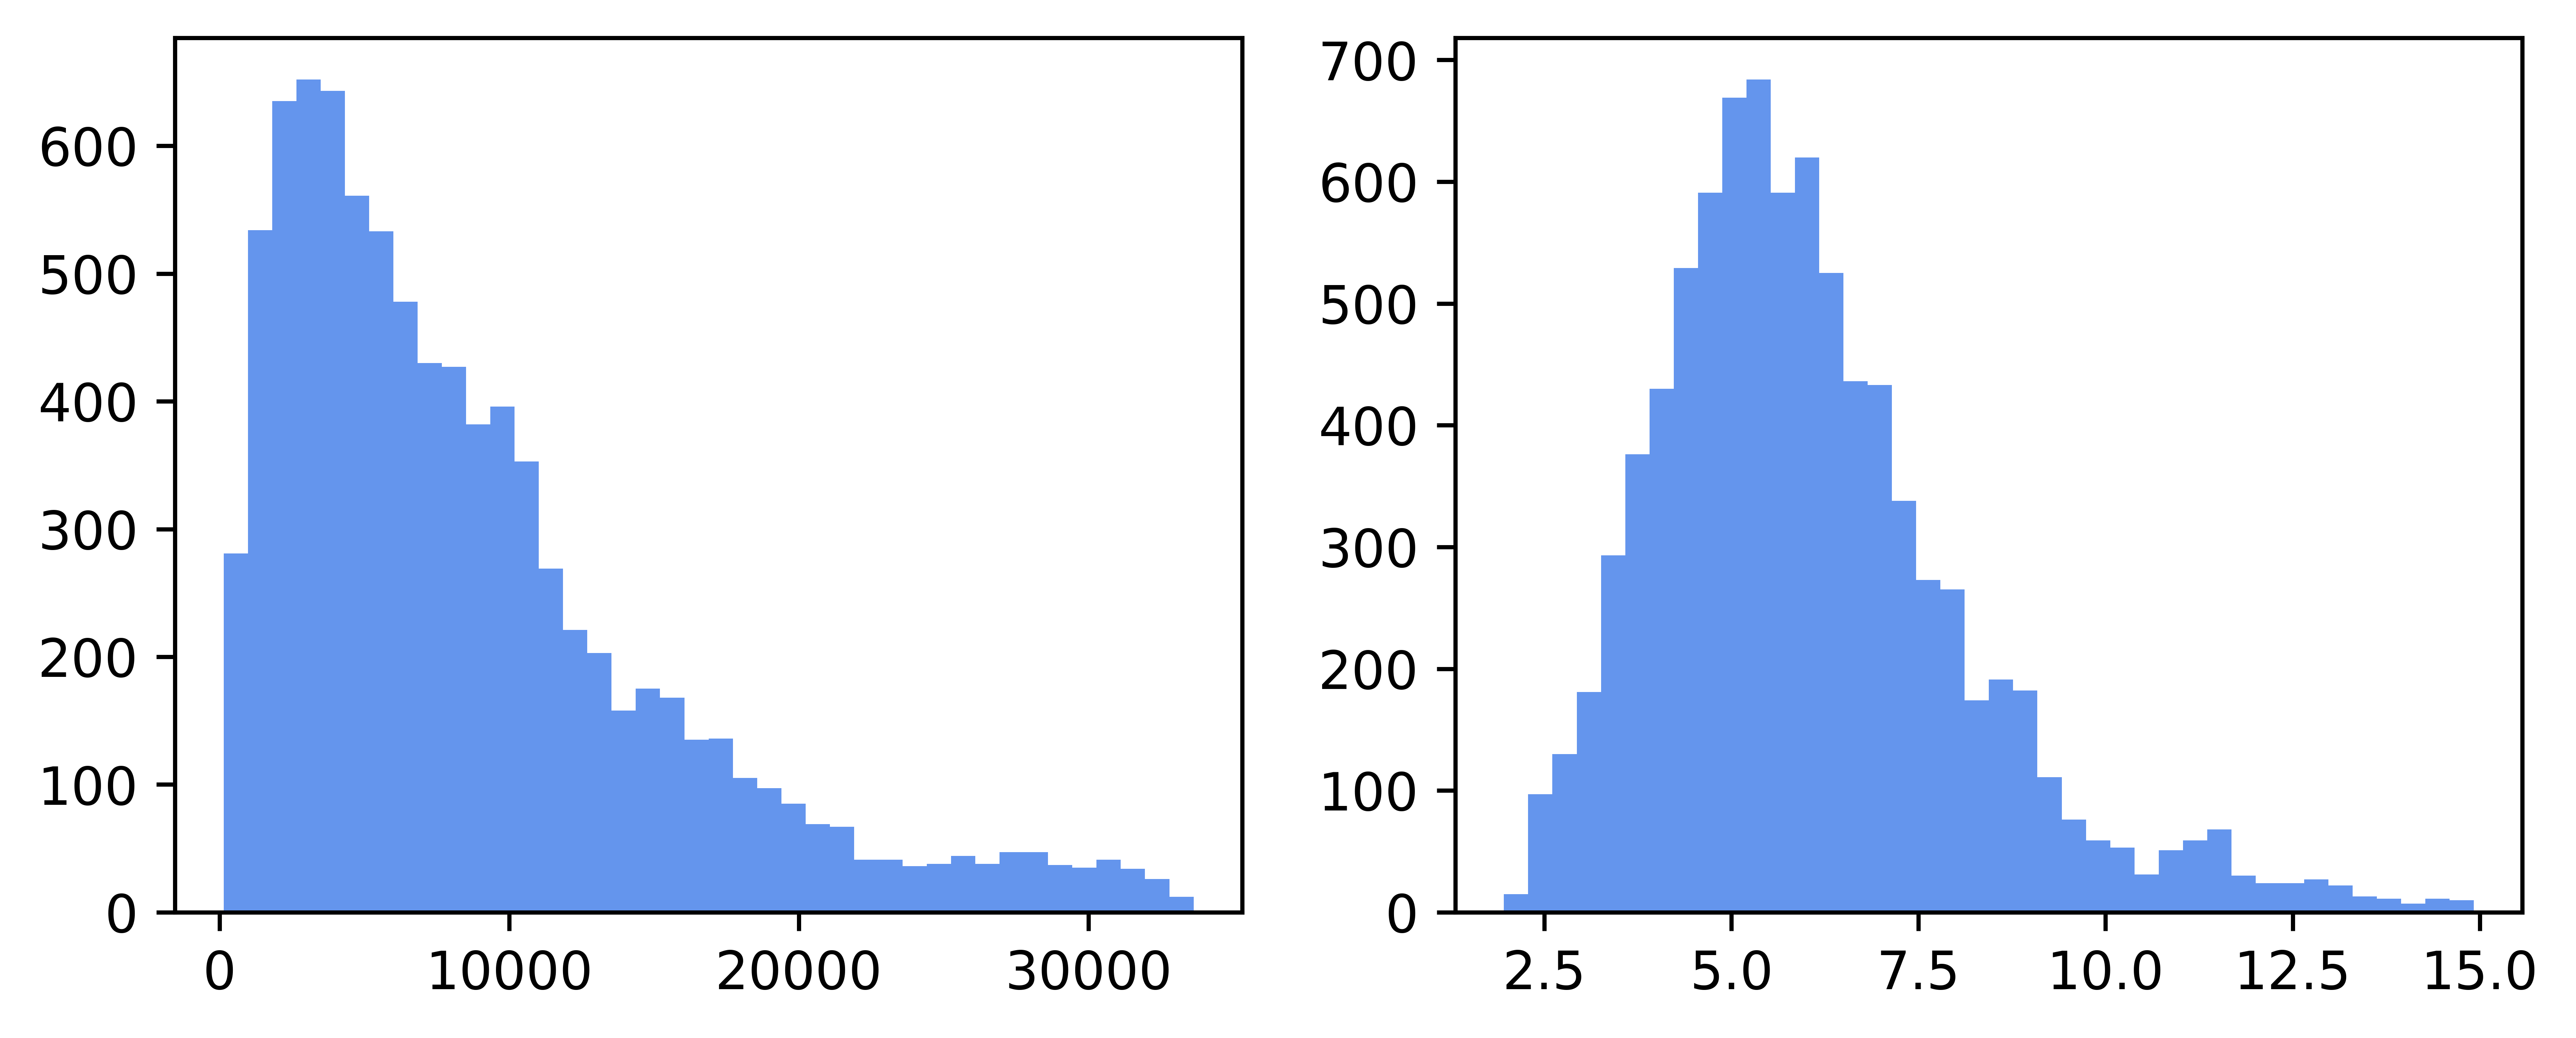

In [19]:
# Show distributions
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=1000)
axes[0].hist(data_2016.wind, bins=40, color='cornflowerblue'); 
axes[1].hist(data_2016.v_50m, bins=40, color='cornflowerblue'); 

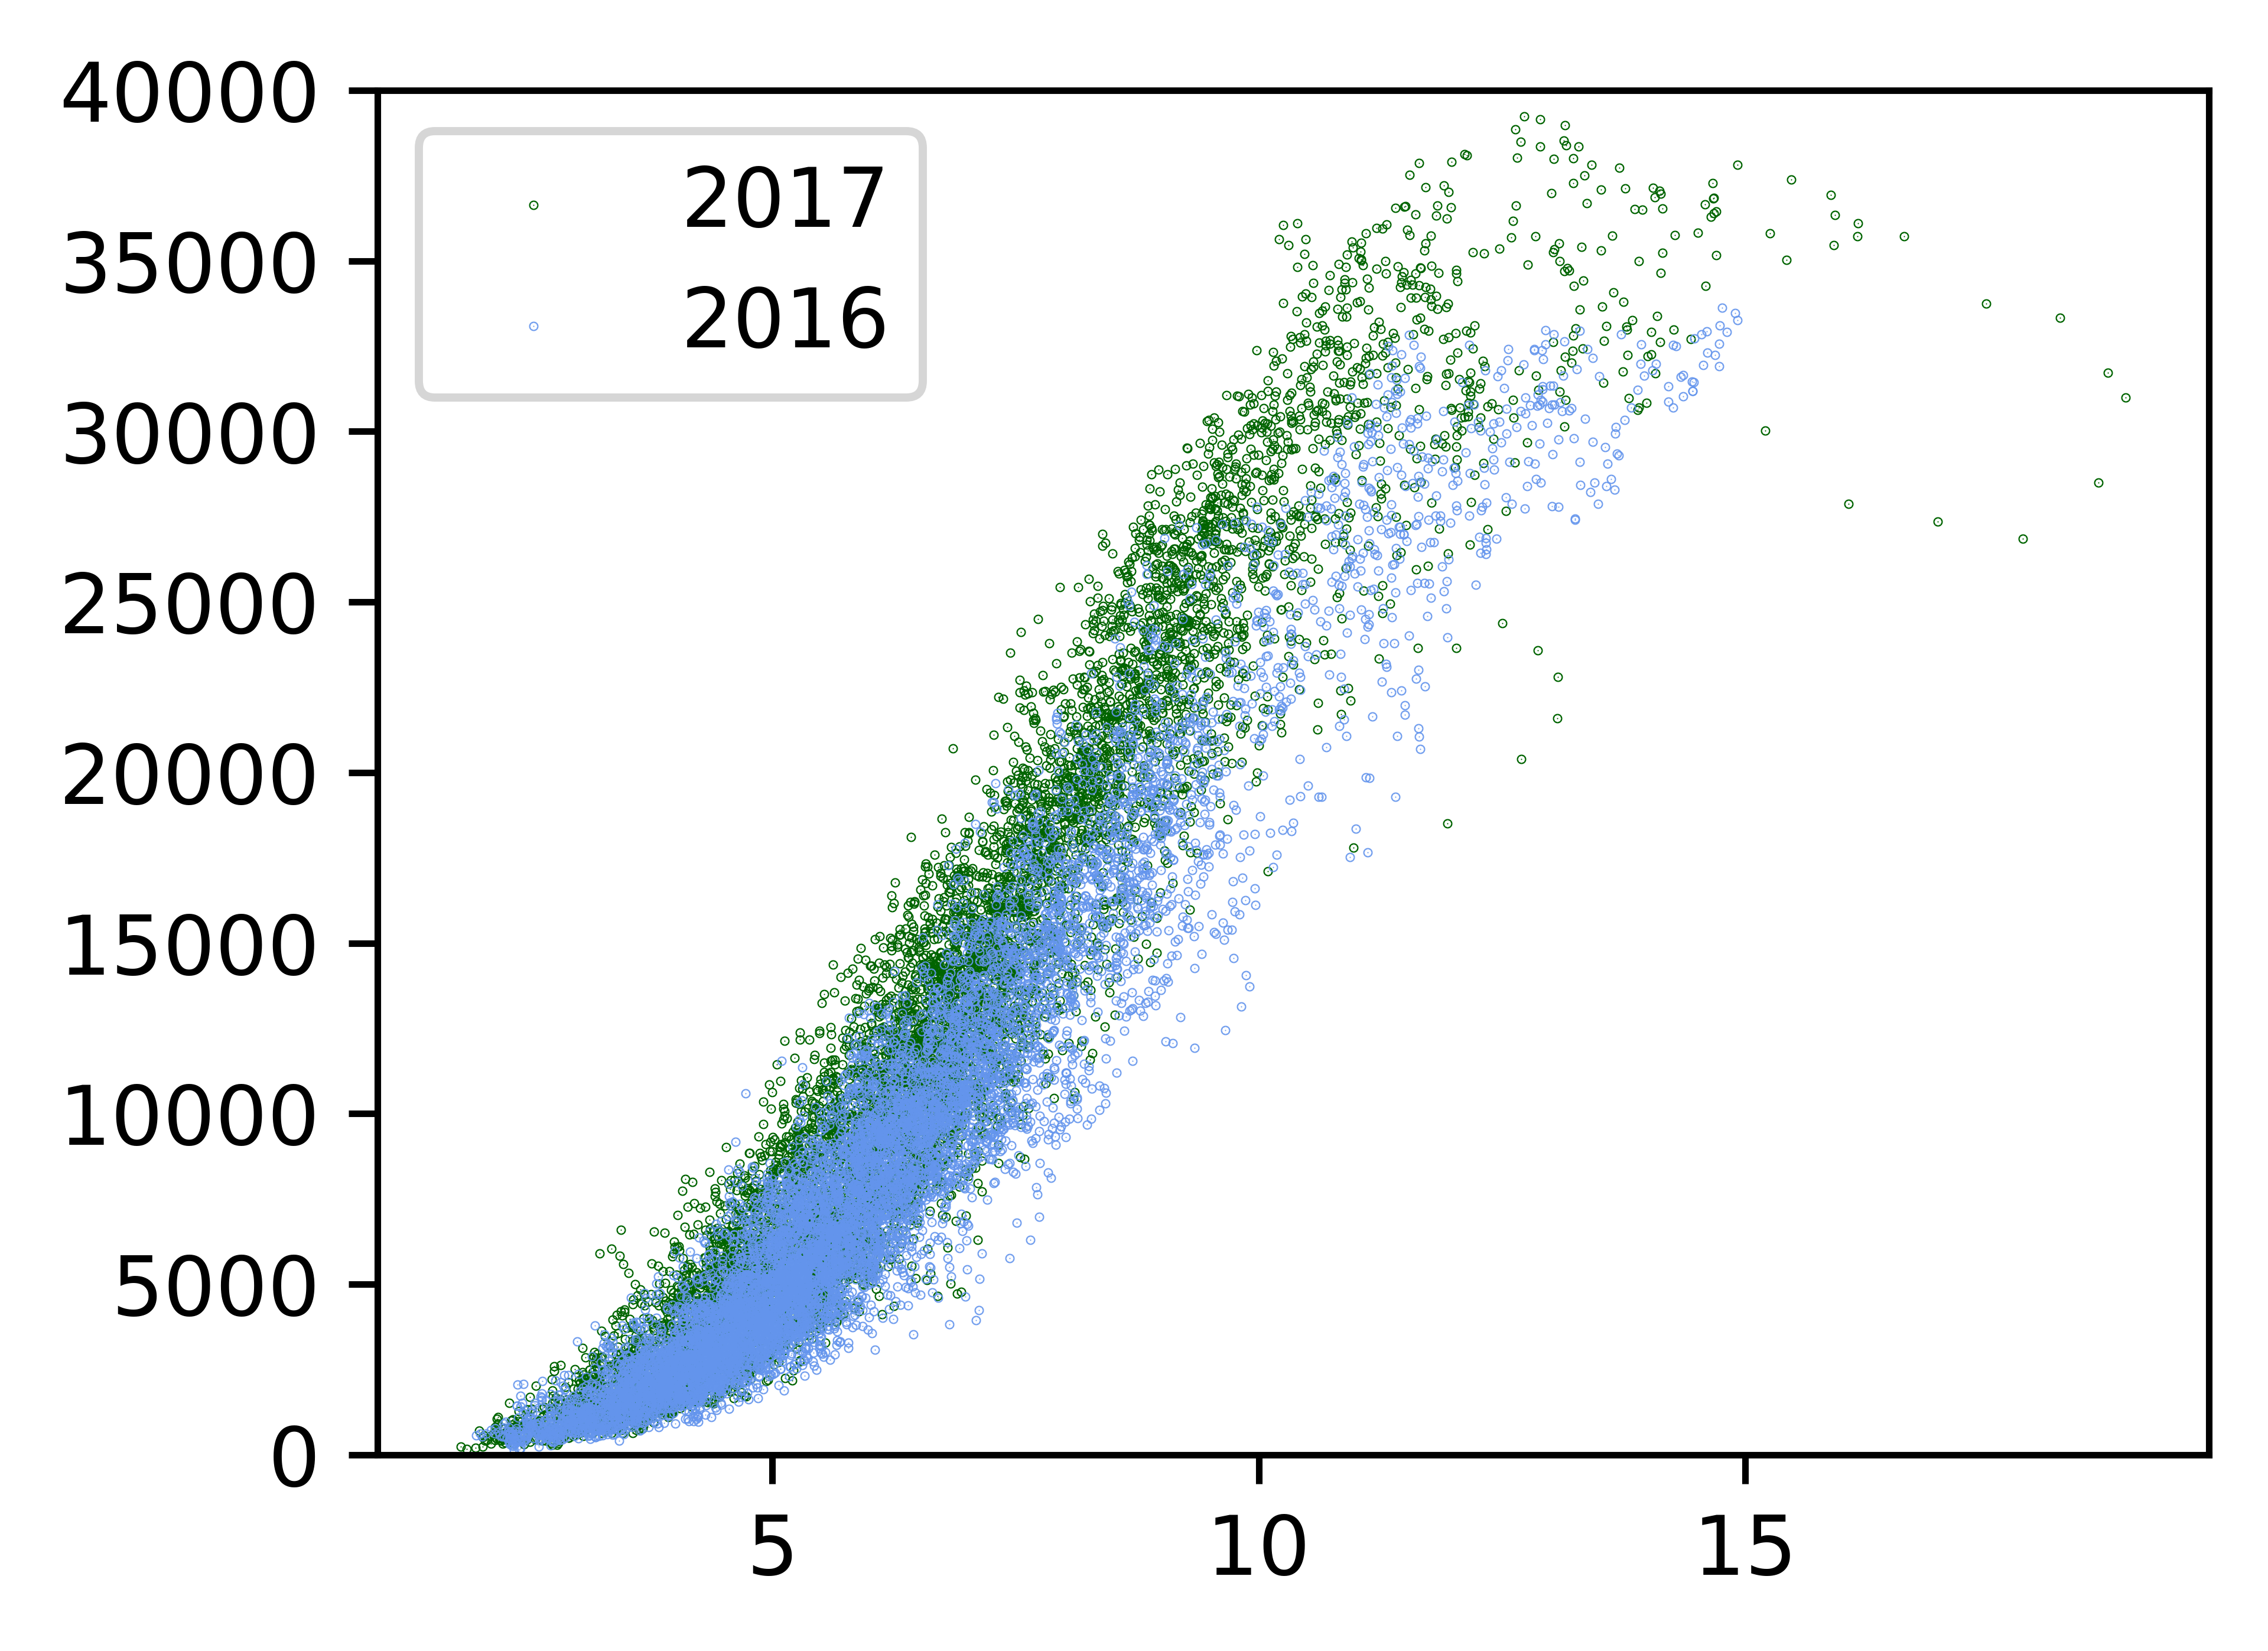

In [20]:
fig, axes = plt.subplots(1, figsize=(4, 3), dpi=1000)
axes.scatter(data_2017.drop(['wind', 'v_2m', 'v_10m'], axis=1).values, 
            data_2017.drop(['v_2m', 'v_10m', 'v_50m'], axis=1).values, 
            s=0.1, label='2017', color='darkgreen', alpha=1, marker='.')
axes.scatter(data_2016.drop(['wind', 'v1', 'v2'], axis=1).values, 
            data_2016.drop(['v1', 'v2', 'v_50m'], axis=1).values, 
            s=0.1, label='2016', color='cornflowerblue', alpha=.9, marker='.')
axes.set_ylim(0,40000)

plt.legend();

## **Bayesian Regression Model (trained with 2016 data)**

In [21]:
# Define testing and training data sets 
x_train = data_2016.drop(['wind', 'v1', 'v2'], axis=1)
y_train = pd.DataFrame(data_2016.wind)

x_test = data_2017.drop(['wind', 'v_2m', 'v_10m'], axis=1)
y_test = pd.DataFrame(data_2017.wind)

In [24]:
# Create Bayesian regression model 
with pm.Model() as model:
    
    # Data
    x = pm.MutableData('x', x_train)
    y = pm.MutableData('y', y_train)
    
    # Priors for unknown model parameters 
    alpha = pm.Normal('α', mu=0, sigma=300)
    beta = pm.Normal('β', mu=3110, sigma=300)
    sigma = pm.HalfNormal('σ', sigma=300)
   
    # Expected value of outcome
    mu = alpha + beta*x

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('μ', mu = mu, sigma = sigma, observed = y)

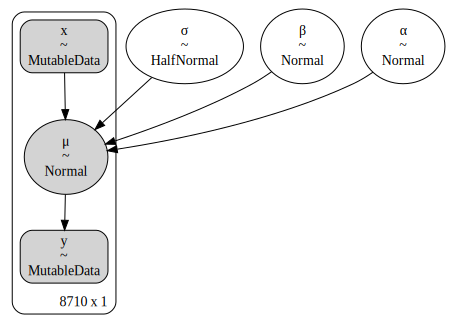

In [25]:
pm.model_to_graphviz(model)

## **Run Fit**

In [26]:
# Draw posterior samples 
with model:
    trace = pm.sample(5000, cores = 4, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 128 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

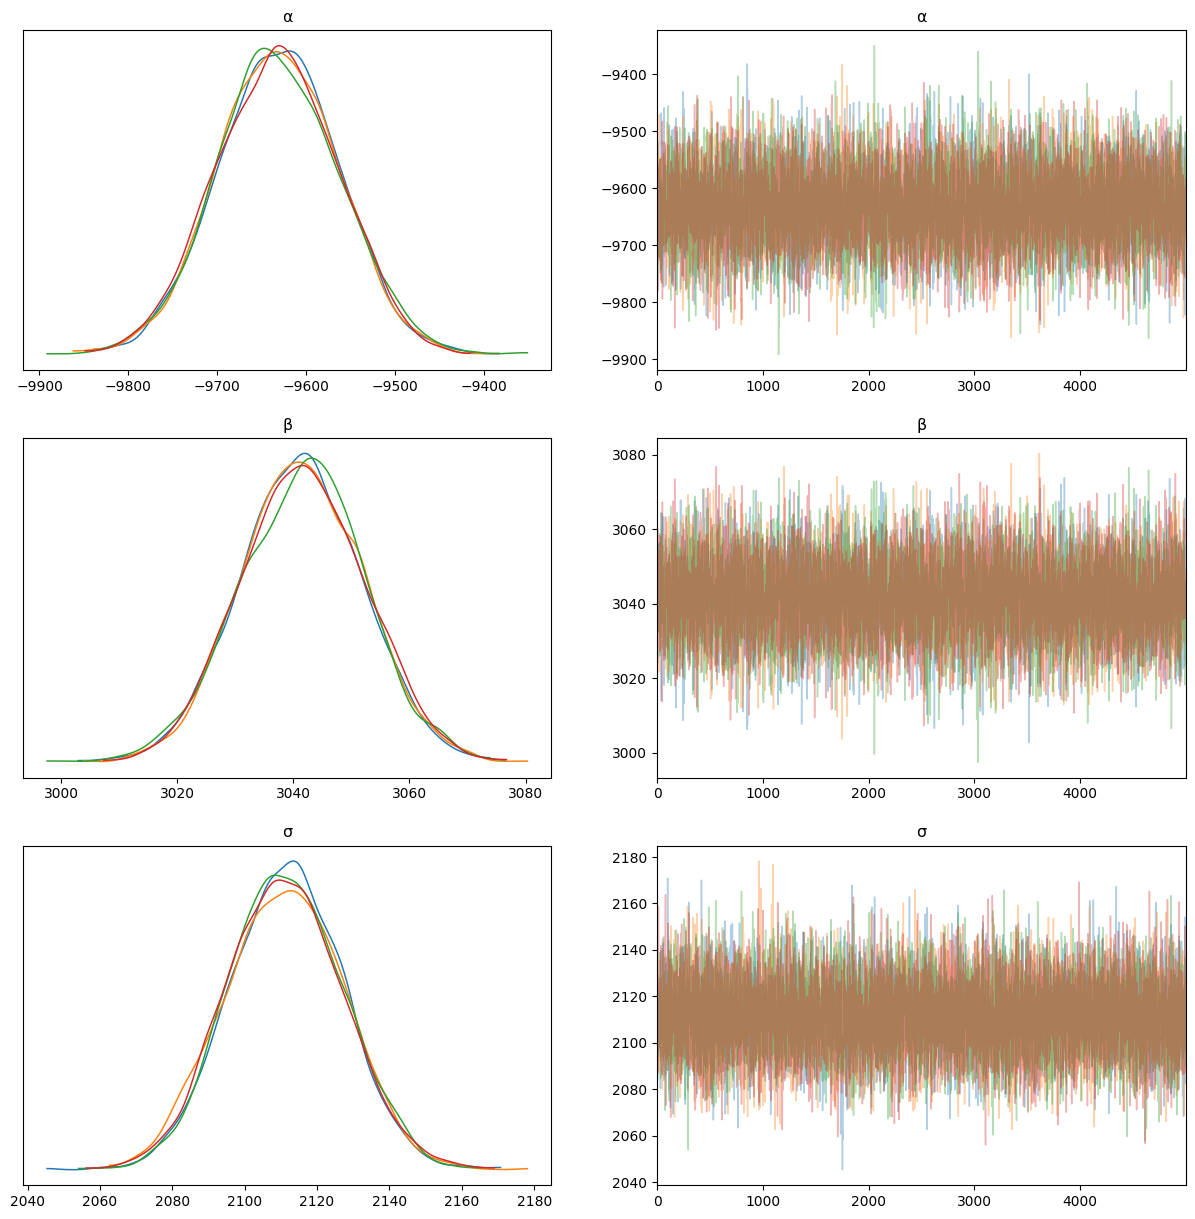

In [27]:
# Show model parameters 
az.plot_trace(trace, compact=False, figsize = (15, 15))

## **Test Model Predictions on 2017 wind speed data**

In [28]:
# Make predictions on test data 
with model:
    pm.set_data({'x': x_test.values})
    pm.set_data({'y': y_test.values})
    y_new = pm.sample_posterior_predictive(trace)

Sampling: [μ]


In [29]:
# Show distribution of predictions
predictions = az.summary(y_new.posterior_predictive.μ, hdi_prob=0.95)
predictions

mean        sd   hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
μ[0, 0]     12685.864  2122.264   8459.547  16789.917     14.898   10.542   
μ[1, 0]     12788.797  2117.015   8712.538  17080.550     14.927   10.555   
μ[2, 0]     12773.098  2101.971   8555.746  16790.159     15.023   10.623   
μ[3, 0]     12832.385  2088.521   8661.549  16845.657     15.047   10.644   
μ[4, 0]     13014.530  2110.633   8676.351  17044.181     15.079   10.680   
...               ...       ...        ...        ...        ...      ...   
μ[8755, 0]  21231.297  2109.357  17133.737  25350.173     15.120   10.692   
μ[8756, 0]  21054.497  2095.342  17020.262  25244.890     15.021   10.621   
μ[8757, 0]  21286.230  2113.903  17035.328  25312.395     15.213   10.758   
μ[8758, 0]  21764.705  2104.564  17624.905  25859.887     15.017   10.631   
μ[8759, 0]  22312.175  2118.071  18151.062  26456.578     15.192   10.743   

            ess_bulk  ess_tail  r_hat  
μ[0, 0]      20294.0   20079.0    1.0  
μ[1, 0]      20112.0   19926.0    1.0  
μ[2, 0]      19577.0   19581.0    1.0  
μ[3, 0]      19261.0   19560.0    1.0  
μ[4, 0]      19588.0   19847.0    1.0  
...              ...       ...    ...  
μ[8755, 0]   19462.0   19516.0    1.0  
μ[8756, 0]   19461.0   20097.0    1.0  
μ[8757, 0]   19324.0   20002.0    1.0  
μ[8758, 0]   19633.0   19465.0    1.0  
μ[8759, 0]   19480.0   18803.0    1.0  

[8760 rows x 9 columns]

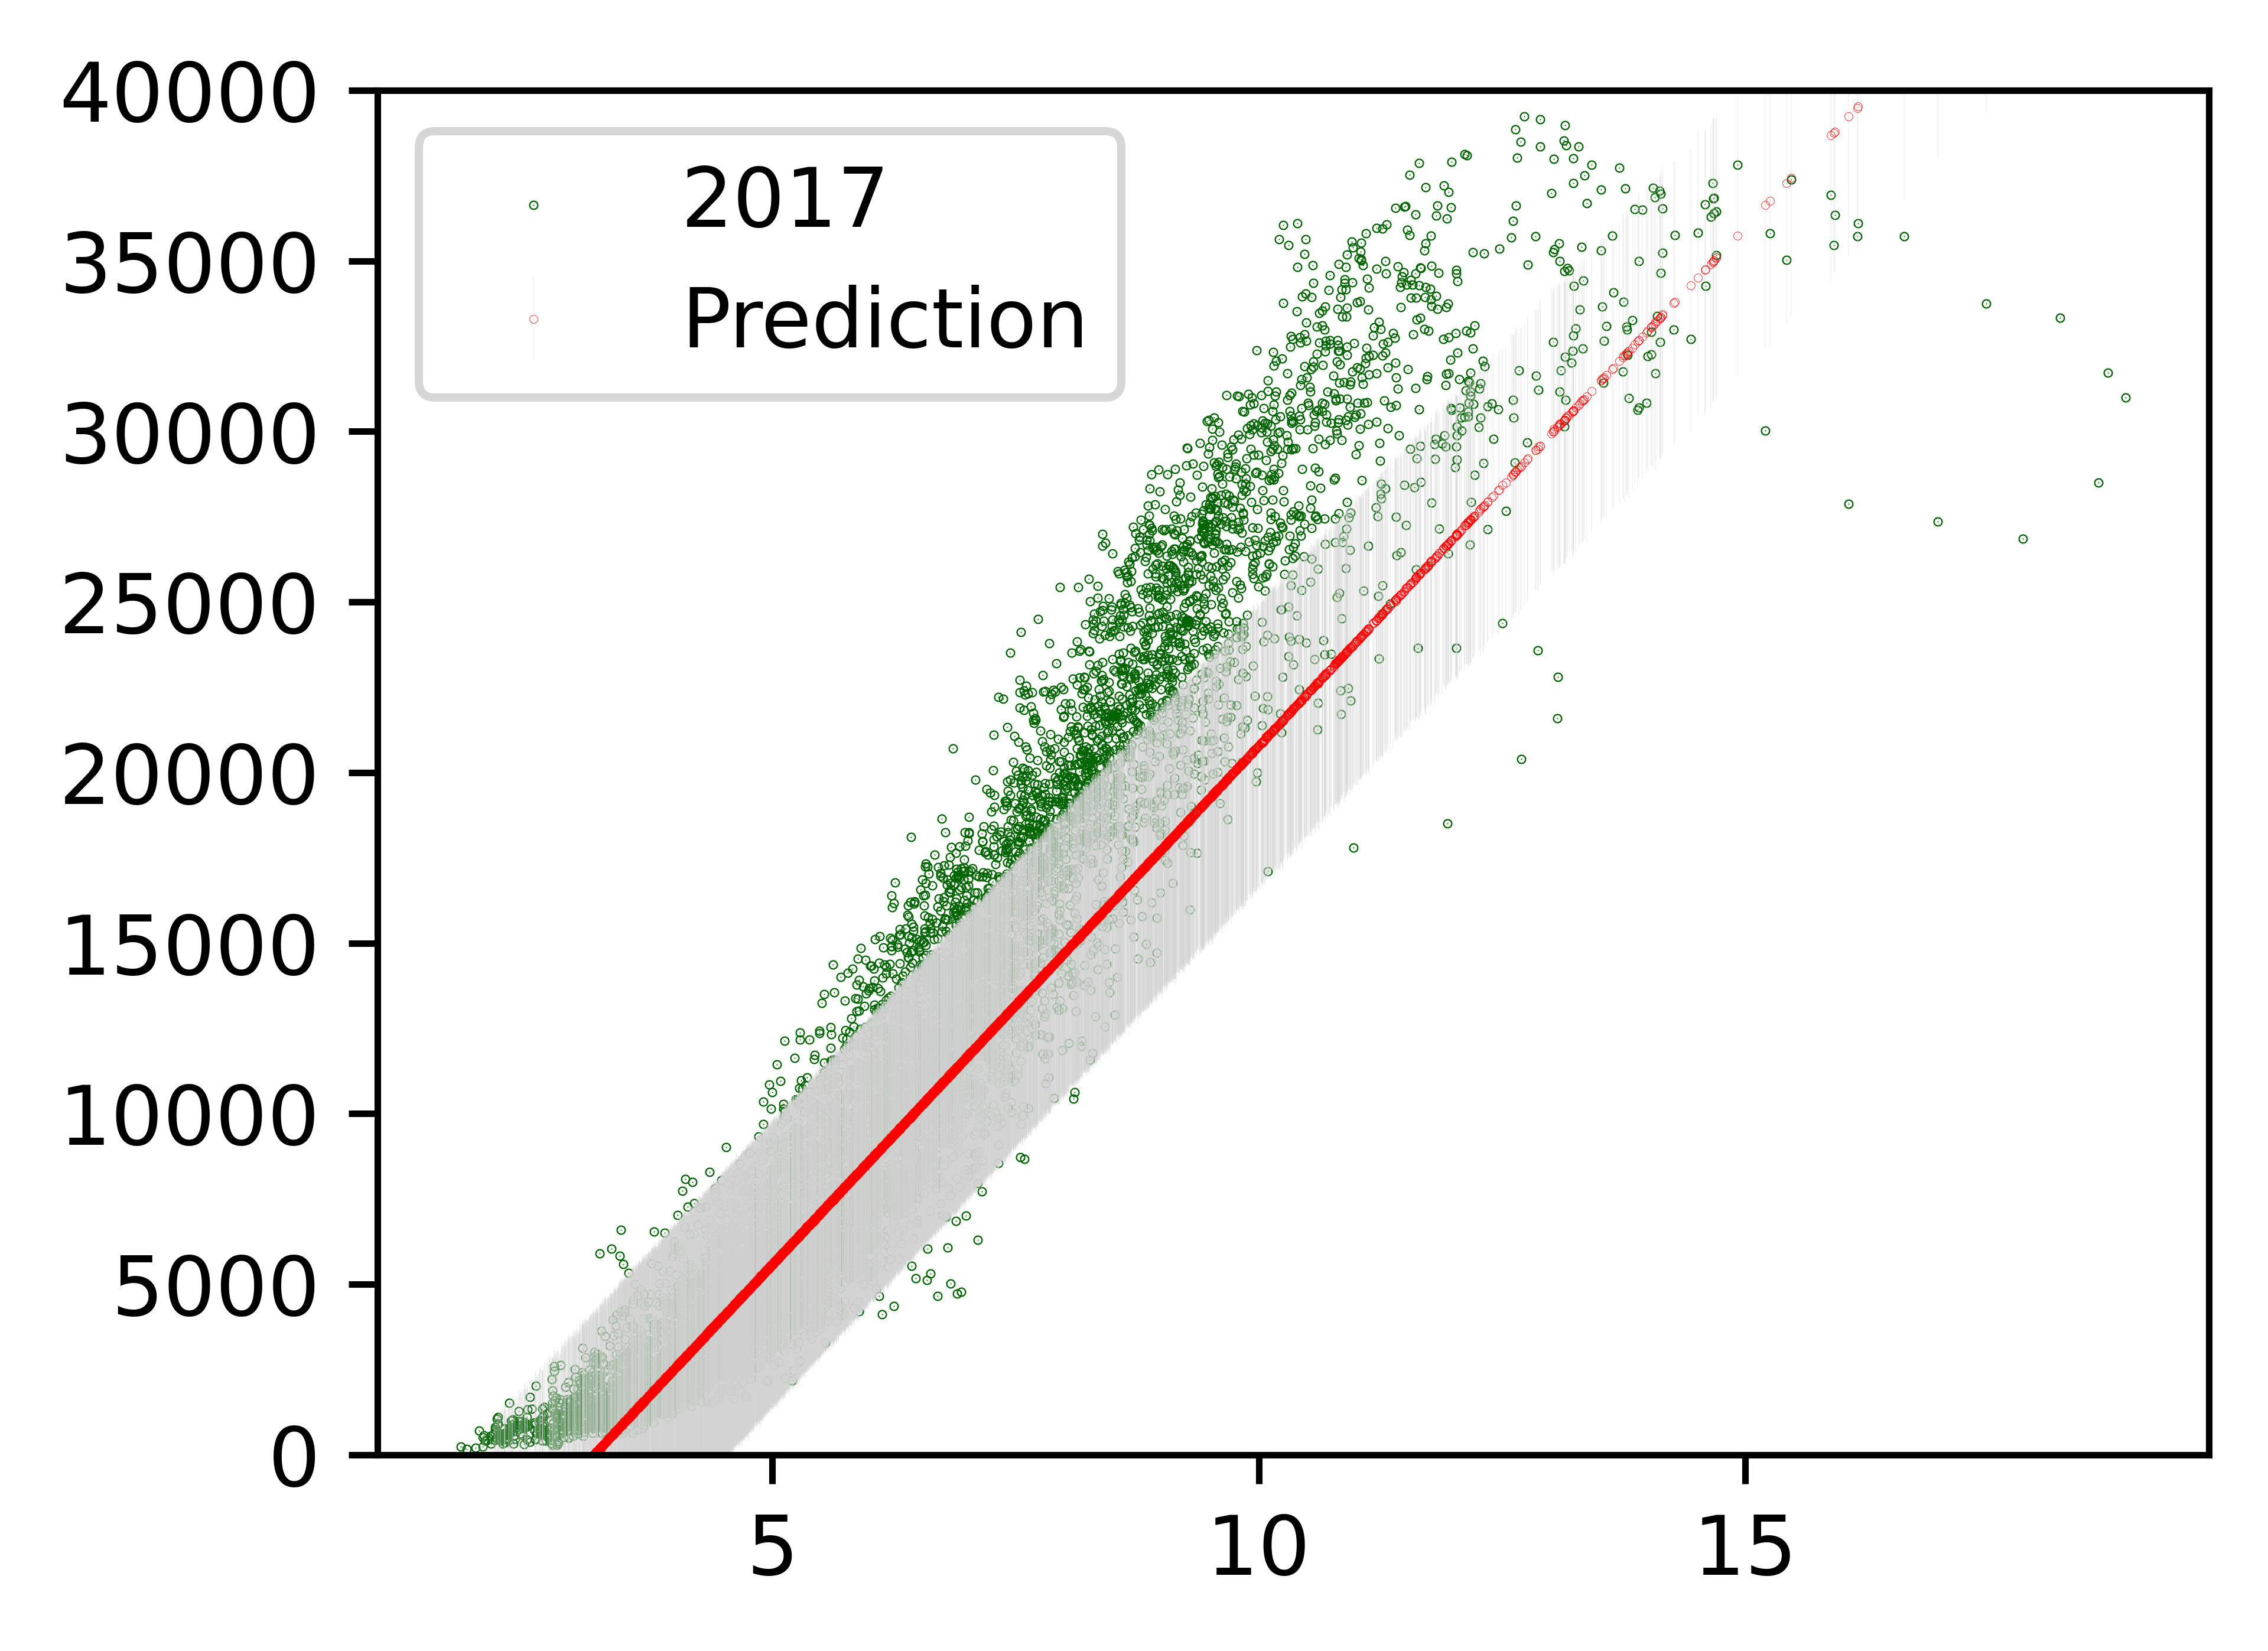

In [45]:
# Estimated values
estimates = pd.Series(pd.DataFrame(predictions).iloc[:, 0])
minus = pd.Series(pd.DataFrame(predictions).iloc[:, 2])
plus = pd.Series(pd.DataFrame(predictions).iloc[:, 3])

fig, axes = plt.subplots(1, figsize=(4, 3), dpi=1000)
plt.errorbar(x_test.values, y=estimates, yerr=pd.DataFrame([estimates-minus, plus-estimates]), fmt='.', color='red',
             ecolor='lightgray', elinewidth=0.03, capsize=0, label='Prediction', ms=0.1);
axes.scatter(data_2017.drop(['wind', 'v_2m', 'v_10m'], axis=1).values, 
            data_2017.drop(['v_2m', 'v_10m', 'v_50m'], axis=1).values, 
            s=0.1, label='2017', color='darkgreen', alpha=1, marker='.')

axes.set_ylim(0,40000)

plt.legend();
plt.savefig('sample.png', bbox_inches='tight')

In [34]:
# Estimated values
estimates = pd.Series(pd.DataFrame(predictions).iloc[:, 0])
estimates.index.name = 'time'
estimates.index = y_test.index

# Lower bound
minus = pd.Series(pd.DataFrame(predictions).iloc[:, 2])
minus.index.name = 'time'
minus.index = y_test.index

# Upper bound
plus = pd.Series(pd.DataFrame(predictions).iloc[:, 3])
plus.index.name = 'time'
plus.index = y_test.index

In [35]:
# Plot results
plt.figure(figsize=(15,5), dpi=1000)
plt.errorbar(data_2017.index, y=estimates, yerr=pd.DataFrame([estimates-minus, plus-estimates]), fmt='o', color='red',
             ecolor='lightgray', elinewidth=3, capsize=0, label='Predicted');
plt.plot(data_2017.index, data_2017.wind, color='black', label='Measured')
plt.xlabel('Date')
plt.ylabel('Wind energy generation (MW)')
plt.title('95% HDI of 2017 wind energy generation predictions compared to measured values')
plt.xlim(pd.Timestamp('2017-12-01'), pd.Timestamp('2017-12-15'))
plt.ylim(0, 40000)
plt.legend()
plt.show()